In [ ]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        # --- 수정된 부분: 신경망 구조 강화 ---
        self.hidden_nodes = [24, 24] 
        self.learning_rate = 0.001
        
        self.model = self.build_model()
        self.target_model = self.build_model() 

        self.discount_rate = 0.99 # <--- 수정된 부분: 감가율을 약간 높여 미래 가치를 더 고려
        
        self.episode_num = 500        
        
        self.replay_memory_limit = 2000
        self.replay_size = 32
        self.buffer_train_start = 200 # <--- 추가된 부분: 버퍼가 일정 크기 이상일 때 학습 시작
        self.replay_memory = deque(maxlen=self.replay_memory_limit) # <--- 수정된 부분: deque 사용

        # --- 수정된 부분: Epsilon 감소 방식을 곱셈 방식으로 변경 ---
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        
        self.moving_avg_size = 10 # <--- 수정된 부분: 평균 점수 계산 기간 단축
        self.reward_list = []
        self.moving_avg_list = []        

    def build_model(self):
        input_states = Input(shape=(self.state_size,), name='input_states')
        # --- 수정된 부분: 더 깊고 넓은 신경망, 활성화 함수로 relu 사용 ---
        x = Dense(self.hidden_nodes[0], activation='relu')(input_states)
        x = Dense(self.hidden_nodes[1], activation='relu')(x)
        out_actions = Dense(self.action_size, activation='linear', name='output')(x)

        model = tf.keras.models.Model(inputs=input_states, outputs=out_actions)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='mean_squared_error')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def train(self):
        self.update_target_model() 
        self.model.summary()
        scores, avg_scores, episodes = [], [], []

        for episode in range(self.episode_num):
            state, _ = self.env.reset()
            done = False
            score = 0

            while not done:
                # 1. 행동 결정
                action = self.get_action(state[np.newaxis, :])
                
                # 2. 행동 실행 및 결과 획득
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                # 3. 리플레이 버퍼에 경험 저장 (환경 기본 보상 사용)
                self.replay_memory.append((state, action, reward, next_state, done))

                # --- 수정된 부분: 매 스텝마다 학습 진행 ---
                if len(self.replay_memory) >= self.buffer_train_start:
                    self.train_mini_batch()

                score += reward
                state = next_state
            
            # 에피소드 종료 시 타겟 네트워크 업데이트
            self.update_target_model()

            scores.append(score)
            avg_score = np.mean(scores[-self.moving_avg_size:])
            avg_scores.append(avg_score)
            episodes.append(episode)
            
            print(f'episode: {episode:3d} | score: {score:3.0f} | avg_score: {avg_score:6.2f} | buffer: {len(self.replay_memory):4d} | epsilon: {self.epsilon:.4f}')

    def get_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def train_mini_batch(self):
        # --- 수정된 부분: Epsilon 감소를 학습 시점에 수행 ---
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        batch = random.sample(self.replay_memory, self.replay_size)
        
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for s, a, r, ns, d in batch:
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(ns)
            dones.append(d)

        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        dones = np.array(dones)

        q_next_values = self.target_model.predict(next_states, verbose=0)
        max_q_next = np.max(q_next_values, axis=1)
        
        targets = rewards + self.gamma * max_q_next * (1 - dones)
        
        with tf.GradientTape() as tape:
            q_values = self.model(states)
            action_indices = tf.stack([tf.range(self.replay_size), actions], axis=1)
            q_sa = tf.gather_nd(q_values, action_indices)
            loss = tf.keras.losses.mean_squared_error(targets, q_sa)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

if __name__ == "__main__":
    # collections.deque를 사용하기 위해 Agent 선언을 main 안으로 이동
    from collections import deque
    agent = Agent()
    agent.train()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 12)                60        
                                                                 
 output (Dense)              (None, 2)                 26        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
episode:0, moving_avg:35.00, rewards_avg:35.00
episode:10, moving_avg:31.64, rewards_avg:31.64
episode:20, moving_avg:27.30, rewards_avg:27.67
episode:30, moving_avg:20.65, rewards_avg:24.55
episode:40, moving_avg:17.15, rewards_avg:22.54
episode:50, moving_avg:17.80, rewards_avg:21.90
episode:60, moving_avg:20.05, rewards_av

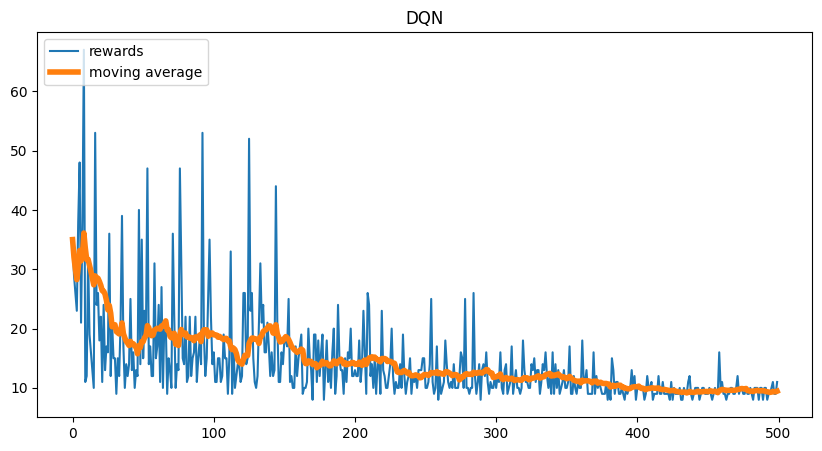

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('DQN')
plt.show()